In [83]:
import numpy as np
import requests
import pandas as pd
import seaborn as sns

In [84]:
# Read in the two restaurants' daily data
url = 'https://s3.us-east-2.amazonaws.com/example.data/fish_restaurant.xls'

low_waste = pd.read_excel(url, sheet_name = 'Low-waste Restaurant', skiprows = 9)
high_waste = pd.read_excel(url, sheet_name = 'High-waste Restaurant ', skiprows = 9)

# Combine the low waste and high waste data into a single dataframe
low_waste['restaurant'] = 'low_waste'
high_waste['restaurant'] = 'high_waste'
fish = pd.concat([low_waste, high_waste], axis=0).reset_index(drop=True)

## Counterfactual Analysis

#### Question
Holding all other variables constant, should Fenmark Fish Restaurant reduce wastage in order to maximize profits?

#### Approach to Answer
Counterfactual analysis that compares what the profits would have been over the previous year at every possible daily order count between 1 and each restaurant's respective, current daily order count.

In [85]:
# Set static parameters
revenue_pf = 15 # revenue per fish
cost_pf = 6 # cost per fish

In [86]:
# Looping function of different order count iterations for each restaurant

proformas = pd.DataFrame()

for focal_restaurant in list(fish.restaurant.drop_duplicates()):
  
  focal = fish[fish['restaurant'] == focal_restaurant].reset_index(drop=True)

  order_size = []
  sales = []
  wastage = []
  revenue = []
  cost = []
  profit = []

  for i in range(1, max(focal.Sales+1)):
    
    '''
    For every day:
      - The new daily sales is the lesser of either the daily order count iteration
        or the actual sales for that day.
      - The new daily wastage is the lesser of either the daily order count iteration
        
    '''
    sales0 = np.sum(np.where(focal['Sales'] >= i, i, focal['Sales']))
    wastage0 = np.sum(np.where(focal['Sales'] >= i, 0, i - focal['Sales']))

    revenue0 = sales0*revenue_pf
    cost0 = sales0*cost_pf+wastage0*cost_pf
    profit0 = revenue0 - cost0
    
    order_size.append(i)
    sales.append(sales0)
    wastage.append(wastage0)
    revenue.append(revenue0)
    cost.append(cost0)
    profit.append(profit0)

  proformas0 = pd.DataFrame({'order_size': order_size,
                             'sales': sales,
                             'wastage': wastage,
                             'revenue': revenue,
                             'cost': cost,
                             'profit': profit})
  
  proformas0['restaurant'] = focal_restaurant
  
  proformas = pd.concat([proformas, proformas0])


proformas = proformas.reset_index(drop=True)

In [87]:
'''
For each restaurant and each iterated order size, 
calculate the difference in profit between the current 
iteration order size (x) and the previous iteration order size (x-1)
'''
proformas['lag'] = proformas.groupby('restaurant')['profit'].shift(1)
proformas['profit_diff'] = proformas['profit'] - proformas['lag']

In [88]:
# Set visualization function
sns.set(rc = {'figure.figsize':(6,4)})

def var_proforma_compare(xvar, yvar):
  ax = sns.lineplot(data = proformas, x = xvar, y = yvar, hue = 'restaurant')
  ax.set_title(f'{xvar} vs. {yvar} by restaurant')

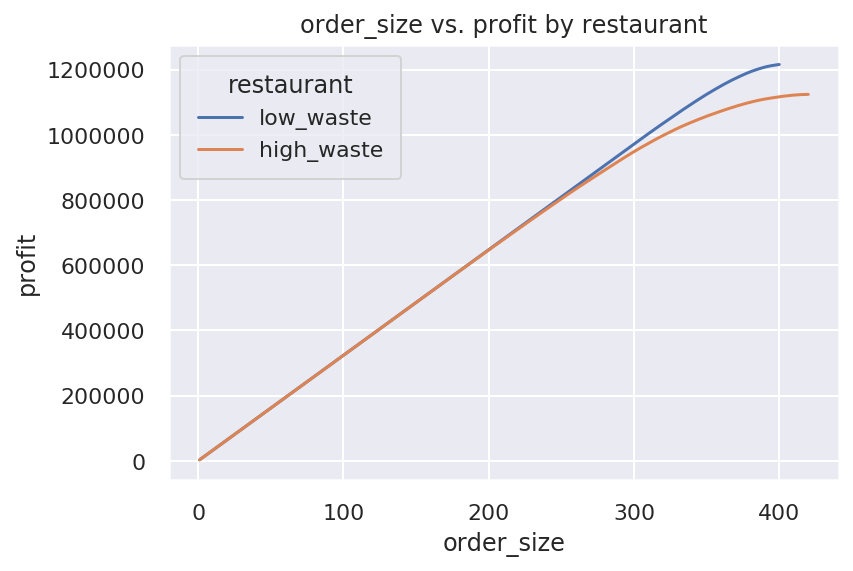

In [89]:
var_proforma_compare('order_size', 'profit')

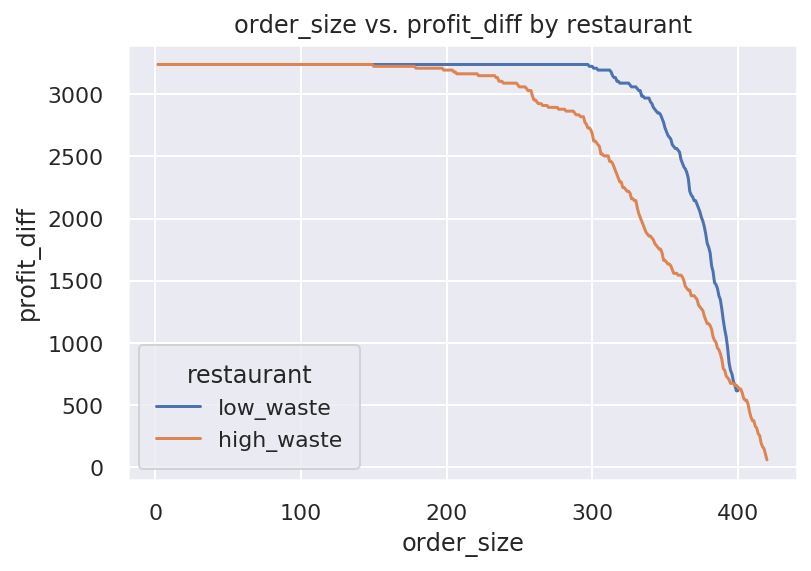

In [90]:
var_proforma_compare('order_size', 'profit_diff')

### Conclusion
Neither restaurant would be better off by decreasing the size of their daily orders. Between an order of 1 fish and the current daily order for each restaurant, their current daily order maximizes profits over the past year of experience.

The second plot above shows that the difference in profits between the current iteration order size (x) and the previous iteration order size (x-1) drops off more steeply for the "high waste" restaurant. This is due to the fact that the "low waste" restaurant's daily sales distribution has less variance than "high waste" restaurant's daily sales distribution, and both distributions are severly underdispersed.

### Recommendation
Increase the daily fish order size for both restaurants, though not sure by how much since true fish sales demand is unknown on days where sales are currently capped by the order limit. Based on both plots above, it seems as though the "low waste" restaurant would benefit from a larger order increase than the "high waste" restaurant.